In [1]:
import optuna
from sklearn.model_selection import KFold

import pandas as pd
import numpy as np
import seaborn as sns
# 시계열 data split
from sklearn.model_selection import TimeSeriesSplit
# timeseriessplit 시각화
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
# 모델
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')

In [2]:
# timeseriessplit 시각화용 함수
def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

In [3]:
# blocked TimeSeriesSplit 용 class 정의
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
    
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

# training 데이터 셋 만들기

## 1. gens : 실제 발전량 ( y로 쓸 예정 ) 
## 2. p_gens : 모델별 발전량 ( x변수로 추가 할 예정 )
## 3. wf : 기상 예측량 ( x변수로 추가 할 예정 )

In [4]:
gens = pd.read_csv("../gens.csv")
p_gens = pd.read_csv("../pred.csv")
wf = pd.read_csv("../weather_forecast.csv")
add_gens = pd.read_csv('../add_gens.csv')

In [5]:
gens = pd.concat([gens, add_gens], axis = 0)

## 날씨 예측을 10시에 한번 17시에 한번 진행 함으로 2개로 나눠야함.

In [6]:
# 날씨 예측량을 round1,2로 분리함
wf_round1 = wf[wf["round"]==1]
wf_round2 = wf[wf["round"]==2]

In [7]:
wf_round1.drop(["round"],axis=1,inplace=True)
wf_round2.drop(["round"],axis=1,inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_31440\3743235756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wf_round1.drop(["round"],axis=1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_31440\3743235756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wf_round2.drop(["round"],axis=1,inplace=True)


## p_gens를 x변수로 만들기 위해서 모델별로 분리

In [8]:
# 발전량 예측량을 모델별로 분리해서 변수로 만들라고 분리하는거
# round1에 대해 진행할 경우에 이거 실행
p_gens10 = p_gens.loc[(p_gens["model_id"]==0) & (p_gens["round"]==1)].reset_index()
p_gens11 = p_gens.loc[(p_gens["model_id"]==1) & (p_gens["round"]==1)].reset_index()
p_gens12 = p_gens.loc[(p_gens["model_id"]==2) & (p_gens["round"]==1)].reset_index()
p_gens13 = p_gens.loc[(p_gens["model_id"]==3) & (p_gens["round"]==1)].reset_index()
p_gens14 = p_gens.loc[(p_gens["model_id"]==4) & (p_gens["round"]==1)].reset_index()


In [9]:
# 발전량 예측량을 모델별로 분리해서 변수로 만들라고 분리하는거
# round2에 대해 진행할 경우에 이거 실행
p_gens20 = p_gens.loc[(p_gens["model_id"]==0) & (p_gens["round"]==2)].reset_index()
p_gens21 = p_gens.loc[(p_gens["model_id"]==1) & (p_gens["round"]==2)].reset_index()
p_gens22 = p_gens.loc[(p_gens["model_id"]==2) & (p_gens["round"]==2)].reset_index()
p_gens23 = p_gens.loc[(p_gens["model_id"]==3) & (p_gens["round"]==2)].reset_index()
p_gens24 = p_gens.loc[(p_gens["model_id"]==4) & (p_gens["round"]==2)].reset_index()

## p_gens 변수로 만들어진 데이터 셋, wf로 만든 데이터셋을 통합해야함. 시간을 기준으로 통합 예정

In [10]:
# p_gens(모델 예측량) 데이터 프레임 생성
x_df1 = pd.DataFrame({"m0": p_gens10["amount"],"m1": p_gens11["amount"],
              "m2": p_gens12["amount"],"m3": p_gens13["amount"],"m4":p_gens14["amount"],
              "time" : p_gens10["time"]})
x_df2 = pd.DataFrame({"m0": p_gens20["amount"],"m1": p_gens21["amount"],
              "m2": p_gens22["amount"],"m3": p_gens23["amount"],"m4":p_gens24["amount"],
              "time" : p_gens20["time"]})

In [11]:
# 10월 발전량 데이터 추가 round 1
for i in range(21,32):
    exec(f"a = pd.read_csv('../data/gen_fcst_10_2023-10-{i}.csv')")
    a.columns = ["time","m0","m1","m2","m3","m4"]
    a = a[["m0","m1","m2","m3","m4","time"]]
    x_df1 = pd.concat([x_df1,a],axis=0)
    

# 10월 발전량 데이터 추가 round 2
for i in range(21,32):
    exec(f"a = pd.read_csv('../data/gen_fcst_17_2023-10-{i}.csv')")
    a.columns = ["time","m0","m1","m2","m3","m4"]
    a = a[["m0","m1","m2","m3","m4","time"]]
    x_df2 = pd.concat([x_df2,a],axis=0)

In [12]:
# 11월 발전량 데이터 추가 round 1
for i in range(1,10):
    exec(f"a = pd.read_csv('../data/gen_fcst_10_2023-11-0{i}.csv')")
    a.columns = ["time","m0","m1","m2","m3","m4"]
    a = a[["m0","m1","m2","m3","m4","time"]]
    x_df1 = pd.concat([x_df1,a],axis=0)
    
for i in range(10,13):
    exec(f"a = pd.read_csv('../data/gen_fcst_10_2023-11-{i}.csv')")
    a.columns = ["time","m0","m1","m2","m3","m4"]
    a = a[["m0","m1","m2","m3","m4","time"]]
    x_df1 = pd.concat([x_df1,a],axis=0)

# 11월 발전량 데이터 추가 round 2
for i in range(1,10):
    exec(f"a = pd.read_csv('../data/gen_fcst_17_2023-11-0{i}.csv')")
    a.columns = ["time","m0","m1","m2","m3","m4"]
    a = a[["m0","m1","m2","m3","m4","time"]]
    x_df2 = pd.concat([x_df2,a],axis=0)

for i in range(10,13):
    exec(f"a = pd.read_csv('../data/gen_fcst_17_2023-11-{i}.csv')")
    a.columns = ["time","m0","m1","m2","m3","m4"]
    a = a[["m0","m1","m2","m3","m4","time"]]
    x_df2 = pd.concat([x_df2,a],axis=0)

In [13]:
# 10월 날씨 데이터 추가 round 1
for i in range(21,32):
    exec(f"a = pd.read_csv('../data/weather_forecasts/wf10_2023-10-{i}.csv')")
    wf_round1 = pd.concat([wf_round1,a],axis=0)
    

# 10월 날씨 데이터 추가 round 2
for i in range(21,32):
    exec(f"a = pd.read_csv('../data/weather_forecasts/wf17_2023-10-{i}.csv')")
    wf_round2 = pd.concat([wf_round2,a],axis=0)

In [14]:
# 11월 날씨 데이터 추가 round 1
for i in range(1,10):
    exec(f"a = pd.read_csv('../data/weather_forecasts/wf10_2023-11-0{i}.csv')")
    wf_round1 = pd.concat([wf_round1,a],axis=0)

for i in range(10,13):
    exec(f"a = pd.read_csv('../data/weather_forecasts/wf10_2023-11-{i}.csv')")
    wf_round1 = pd.concat([wf_round1,a],axis=0)

# 11월 날씨 데이터 추가 round 2
for i in range(1,10):
    exec(f"a = pd.read_csv('../data/weather_forecasts/wf17_2023-11-0{i}.csv')")
    wf_round2 = pd.concat([wf_round2,a],axis=0)
    
for i in range(10,13):
    exec(f"a = pd.read_csv('../data/weather_forecasts/wf17_2023-11-{i}.csv')")
    wf_round2 = pd.concat([wf_round2,a],axis=0)

In [15]:
# time을 기준으로 두 데이터 병합 ( p_gens, wf )
# 1차 모델링의 Y값으로 쓰일 발전량 gens도 같이 병합
# round2에 대해 수행해야하면 wf_round2/ 아니면 wf_round1
xy_df1 = pd.merge(x_df1,wf_round1,on="time")
xy_df1 = pd.merge(xy_df1,gens,on="time")

# 월과 날짜 변수를 추가 할 것임, 또한 시간대를 기준으로 데이터프레임을 3개 생성해야함으로 hour 변수도 추가
xy_df1["time"]=pd.to_datetime(xy_df1["time"])
xy_df1["month"]=xy_df1["time"].dt.month
xy_df1["day"]=xy_df1["time"].dt.day
xy_df1["hour"]=xy_df1["time"].dt.hour

# round2에 대해 수행해야하면 wf_round2/ 아니면 wf_round1
xy_df2 = pd.merge(x_df2,wf_round2,on="time")
xy_df2 = pd.merge(xy_df2,gens,on="time")

# 월2 날짜 변수를 추가 할 것임, 또한 시간대를 기준으로 데이터프레임을 3개 생성해야함으로 hour 변수도 추가
xy_df2["time"]=pd.to_datetime(xy_df2["time"])
xy_df2["month"]=xy_df2["time"].dt.month
xy_df2["day"]=xy_df2["time"].dt.day
xy_df2["hour"]=xy_df2["time"].dt.hour


In [16]:
xy_df1_ori = xy_df1.copy()
xy_df2_ori = xy_df2.copy()

In [17]:
xy_df1 = xy_df1[(xy_df1["month"]==10) | (xy_df1["month"]==11)]
xy_df2 = xy_df2[(xy_df2["month"]==10) | (xy_df2["month"]==11)]
xy_df1.reset_index(drop=True,inplace=True)
xy_df2.reset_index(drop=True,inplace=True)

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
# xy_df1 에 유사도 발전량 추가
make_train1 = xy_df1[["m0","m1","m2","m3","m4","elevation","uv_idx","amount"]]
make_train2 = xy_df1[["m0","m1","m2","m3","m4","elevation","uv_idx","humidity","amount","vis","dew_point","ground_press"]]
feature = make_train1.drop(["amount"],axis=1)
cosine_sim = cosine_similarity(feature,feature)
np.fill_diagonal(cosine_sim, 0)
most_similar_idx = cosine_sim.argmax(axis=1)
for i in range(len(xy_df1)):
    idx = most_similar_idx[i]
    xy_df1.loc[i,"amount1"] = xy_df1.at[idx,"amount"]
    
feature = make_train2.drop(["amount"],axis=1)
cosine_sim = cosine_similarity(feature,feature)
np.fill_diagonal(cosine_sim, 0)
most_similar_idx = cosine_sim.argmax(axis=1)
for i in range(len(xy_df1)):
    idx = most_similar_idx[i]
    xy_df1.loc[i,"amount2"] = xy_df1.at[idx,"amount"]

In [20]:
# xy_df2 에 유사도 발전량 추가
make_train1 = xy_df2[["m0","m1","m2","m3","m4","elevation","uv_idx","amount"]]
make_train2 = xy_df2[["m0","m1","m2","m3","m4","elevation","uv_idx","humidity","amount","vis","dew_point","ground_press"]]
feature = make_train1.drop(["amount"],axis=1)
cosine_sim = cosine_similarity(feature,feature)
np.fill_diagonal(cosine_sim, 0)
most_similar_idx = cosine_sim.argmax(axis=1)
for i in range(len(xy_df2)):
    idx = most_similar_idx[i]
    xy_df2.loc[i,"amount1"] = xy_df2.at[idx,"amount"]
    
feature = make_train2.drop(["amount"],axis=1)
cosine_sim = cosine_similarity(feature,feature)
np.fill_diagonal(cosine_sim, 0)
most_similar_idx = cosine_sim.argmax(axis=1)
for i in range(len(xy_df2)):
    idx = most_similar_idx[i]
    xy_df2.loc[i,"amount2"] = xy_df2.at[idx,"amount"]

In [21]:
# r1
# 시간에 따라 전체 통합된 데이터셋을 3개로 분리
# 7-10, 11-14 , 15-19
xy_df1_1 = xy_df1[(xy_df1["hour"]<=9) & (xy_df1["hour"]>=7)]
xy_df1_2 = xy_df1[(xy_df1["hour"]<=15) & (xy_df1["hour"]>=10)]
xy_df1_3 = xy_df1[(xy_df1["hour"]<=19) & (xy_df1["hour"]>=16)]

In [22]:
# r2
# 시간에 따라 전체 통합된 데이터셋을 3개로 분리
# 7-10, 11-14 , 15-19
xy_df2_1 = xy_df2[(xy_df2["hour"]<=9) & (xy_df2["hour"]>=7)]
xy_df2_2 = xy_df2[(xy_df2["hour"]<=15) & (xy_df2["hour"]>=10)]
xy_df2_3 = xy_df2[(xy_df2["hour"]<=19) & (xy_df2["hour"]>=16)]

In [63]:
# r1
# 1차 모델링에서 사용할 X데이터셋 생성
# 데이터프레임 이름 읽는 법.
# 변수_몇차모델링_시간분리
# 시간 분리는 (1. 7-10 / 2. 11-14 / 3. 15-19)
# ex) x_df1_1 (x데이터셋, 1차 모델링, 7-10)
x1_df1_1 = xy_df1_1[["m0","m1","m2","m3","m4","uv_idx","elevation","amount1","amount2"]]
x1_df1_2 = xy_df1_2[["m0","m1","m2","m3","m4","uv_idx","elevation","amount1","amount2"]]
x1_df1_3 = xy_df1_3[["m0","m1","m2","m3","m4","uv_idx","elevation","amount1","amount2"]]
x1_df2_1 = xy_df1_1.drop(["amount","m0","m1","m2","m3","m4","uv_idx","elevation","time","hour","amount1","amount2","day","month"],axis=1)
x1_df2_2 = xy_df1_2.drop(["amount","m0","m1","m2","m3","m4","uv_idx","elevation","time","hour","amount1","amount2","day","month"],axis=1)
x1_df2_3 = xy_df1_3.drop(["amount","m0","m1","m2","m3","m4","uv_idx","elevation","time","hour","amount1","amount2","day","month"],axis=1)

In [64]:
# r2
# 1차 모델링에서 사용할 X데이터셋 생성
# 데이터프레임 이름 읽는 법.
# 변수_몇차모델링_시간분리
# 시간 분리는 (1. 7-10 / 2. 11-14 / 3. 15-19)
# ex) x_df1_1 (x데이터셋, 1차 모델링, 7-10)
x2_df1_1 = xy_df2_1[["m0","m1","m2","m3","m4","uv_idx","elevation","amount1","amount2"]]
x2_df1_2 = xy_df2_2[["m0","m1","m2","m3","m4","uv_idx","elevation","amount1","amount2"]]
x2_df1_3 = xy_df2_3[["m0","m1","m2","m3","m4","uv_idx","elevation","amount1","amount2"]]
x2_df2_1 = xy_df2_1.drop(["amount","m0","m1","m2","m3","m4","uv_idx","elevation","time","hour","amount1","amount2","day","month"],axis=1)
x2_df2_2 = xy_df2_2.drop(["amount","m0","m1","m2","m3","m4","uv_idx","elevation","time","hour","amount1","amount2","day","month"],axis=1)
x2_df2_3 = xy_df2_3.drop(["amount","m0","m1","m2","m3","m4","uv_idx","elevation","time","hour","amount1","amount2","day","month"],axis=1)

In [66]:
# r1
# 1차 모델링에서 사용할 Y데이터셋 생성
# 표기 법은 X와 동일
# 다만 2차 모델링에서 사용할 Y는 1차 모델링에서 구한 Y_hat을 실제 Y에서 뺀 e임으로 추후에 구해야함
# e = Y - Y_hat
y1_df1_1 = xy_df1_1["amount"]
y1_df1_2 = xy_df1_2["amount"]
y1_df1_3 = xy_df1_3["amount"]

In [73]:
# r2
# 1차 모델링에서 사용할 Y데이터셋 생성
# 표기 법은 X와 동일
# 다만 2차 모델링에서 사용할 Y는 1차 모델링에서 구한 Y_hat을 실제 Y에서 뺀 e임으로 추후에 구해야함
# e = Y - Y_hat
y2_df1_1 = xy_df2_1["amount"]
y2_df1_2 = xy_df2_2["amount"]
y2_df1_3 = xy_df2_3["amount"]

# 모델링1 선형관계 linear or mlp (모델은 바뀔수 있음)

In [67]:
from sklearn.linear_model import LinearRegression

In [76]:
# r1
# 1차 모델링 (변수 모델예측량 + 고도 + 자외선 지수)
lm1 = LinearRegression()
lm1.fit(x1_df1_1, y1_df1_1)
lm2 = LinearRegression()
lm2.fit(x1_df1_2, y1_df1_2)
lm3 = LinearRegression()
lm3.fit(x1_df1_3, y1_df1_3)


LinearRegression()

In [69]:
import joblib
joblib.dump(lm1,"../model/시간1r1유사도추가회귀.pkl")
joblib.dump(lm2,"../model/시간2r1유사도추가회귀.pkl")
joblib.dump(lm3,"../model/시간3r1유사도추가회귀.pkl")

['../model/시간3r1유사도추가회귀.pkl']

In [79]:
# r1
# 2차 모델링에 사용할 y1 데이터 셋 생성
y1_df2_1 = y1_df1_1-lm1.predict(x1_df1_1)
y1_df2_2 = y1_df1_2-lm2.predict(x1_df1_2)
y1_df2_3 = y1_df1_3-lm3.predict(x1_df1_3)

In [80]:
# r2
# 1차 모델링 (변수 모델예측량 + 고도 + 자외선 지수)
lm1 = LinearRegression()
lm1.fit(x2_df1_1, y2_df1_1)
lm2 = LinearRegression()
lm2.fit(x2_df1_2, y2_df1_2)
lm3 = LinearRegression()
lm3.fit(x2_df1_3, y2_df1_3)

LinearRegression()

In [75]:
import joblib
joblib.dump(lm1,"../model/시간1r2유사도추가회귀.pkl")
joblib.dump(lm2,"../model/시간2r2유사도추가회귀.pkl")
joblib.dump(lm3,"../model/시간3r2유사도추가회귀.pkl")

['../model/시간3r2유사도추가회귀.pkl']

In [81]:
# r1
# 2차 모델링에 사용할 y2 데이터 셋 생성
y2_df2_1 = y2_df1_1-lm1.predict(x2_df1_1)
y2_df2_2 = y2_df1_2-lm2.predict(x2_df1_2)
y2_df2_3 = y2_df1_3-lm3.predict(x2_df1_3)

# 모델링2 잔차에 대하여 fitting (target variable Y = y_df2_1, y_df2_2, y_df2_3)

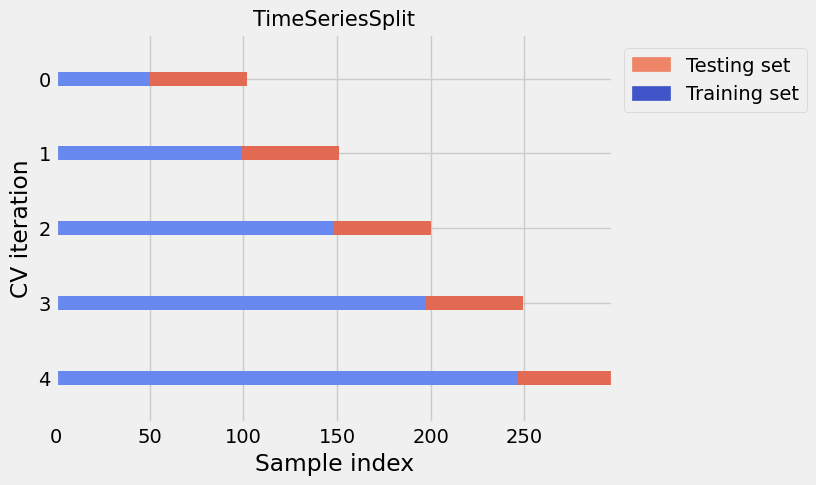

In [82]:
# 1. TimeSeriesSplit 기본
n_split = 5

tscv = TimeSeriesSplit(n_splits=n_split)

plot_cv_indices(tscv, x_df2_1, n_splits=n_split)

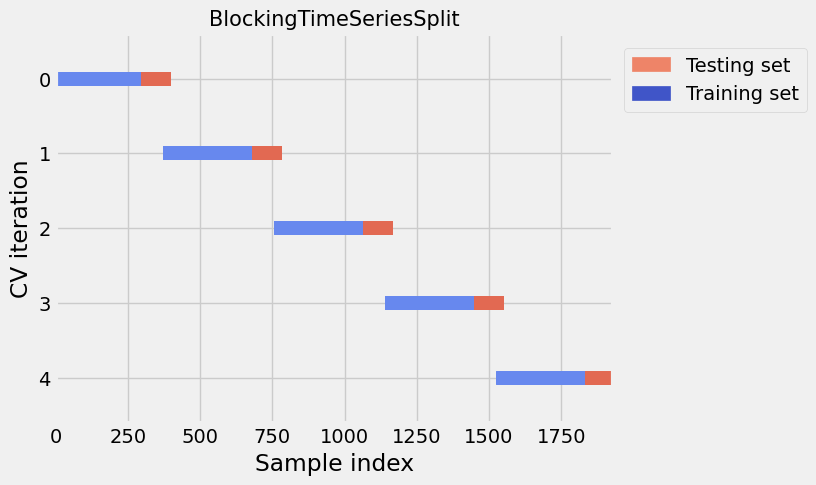

In [23]:
# 2. Blocked TimeSeriesSplit
btscv = BlockingTimeSeriesSplit(n_splits=n_split)
plot_cv_indices(btscv, x_df2_1, n_splits=n_split)

In [ ]:
# 그냥 kfold cv
## optuna 트리모델 설정

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }
    
    kf = KFold(n_splits= 5)
    scores = []
    for i, (train_index, test_index) in enumerate(kf.split(x1_df2_2)):
        x_train, y_train=x1_df2_2.iloc[train_index], y1_df2_2.iloc[train_index]
        x_test, y_test=x1_df2_2.iloc[test_index], y1_df2_2.iloc[test_index]

        lgbm_model=LGBMRegressor(**params, boost_from_average=False,
                                  random_state=42)
        lgbm_model.fit(x_train, y_train)

        y_pred=lgbm_model.predict(x_test)
        score = mean_squared_error(y_test,y_pred)


    return score

In [117]:
## optuna 트리모델 설정
# tscv
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }
    
    
    scores = []
    for i, (train_index, test_index) in enumerate(tscv.split(x2_df2_1)):
        x_train, y_train=x2_df2_1.iloc[train_index], y2_df2_1.iloc[train_index]
        x_test, y_test=x2_df2_1.iloc[test_index], y2_df2_1.iloc[test_index]

        lgbm_model=LGBMRegressor(**params, boost_from_average=False,
                                  random_state=42)
        lgbm_model.fit(x_train, y_train)

        y_pred=lgbm_model.predict(x_test)
        score = mean_squared_error(y_test,y_pred)


    return score

In [118]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2023-11-15 00:06:01,904] A new study created in memory with name: no-name-eb6a371e-83bf-4b0e-8e97-c035f00e96e9
[I 2023-11-15 00:06:02,654] Trial 0 finished with value: 35.930802505266755 and parameters: {'n_estimators': 1757, 'max_depth': 16, 'learning_rate': 0.04234030638781319, 'num_leaves': 17, 'min_child_samples': 34, 'reg_alpha': 0.05682157676171681, 'reg_lambda': 0.28510088753726603}. Best is trial 0 with value: 35.930802505266755.
[I 2023-11-15 00:06:02,814] Trial 1 finished with value: 43.096931523163 and parameters: {'n_estimators': 171, 'max_depth': 18, 'learning_rate': 0.2025719459727967, 'num_leaves': 24, 'min_child_samples': 12, 'reg_alpha': 0.7797053106783707, 'reg_lambda': 0.4086687717415802}. Best is trial 0 with value: 35.930802505266755.
[I 2023-11-15 00:06:02,946] Trial 2 finished with value: 33.422955610651805 and parameters: {'n_estimators': 808, 'max_depth': 6, 'learning_rate': 0.49191801797101375, 'num_leaves': 30, 'min_child_samples': 81, 'reg_alpha': 0.82934

In [119]:
print(study.best_value)
print(study.best_params)

26.53423212205019
{'n_estimators': 317, 'max_depth': 8, 'learning_rate': 0.1656046541597481, 'num_leaves': 3, 'min_child_samples': 58, 'reg_alpha': 0.5331249906654068, 'reg_lambda': 0.05660113084690789}


# 모델 학습 후 저장

In [98]:
import joblib

In [103]:
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x1_df2_1,y1_df2_1)
joblib.dump(model,"../model/시간1r1유사도추가lgbm.pkl")

['../model/시간1r1유사도추가lgbm.pkl']

In [99]:
# 모델 학습 후 저장 !!! 필 히  이름 바 꿀 것!!!!!!11
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x1_df2_2,y1_df2_2)
joblib.dump(model,"../model/시간2r1유사도추가lgbm.pkl")

['../model/시간2r1유사도추가lgbm.pkl']

In [107]:
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x1_df2_3,y1_df2_3)
joblib.dump(model,"../model/시간3r1유사도추가lgbm.pkl")

['../model/시간3r1유사도추가lgbm.pkl']

In [120]:
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x2_df2_1,y2_df2_1)
joblib.dump(model,"../model/시간1r2유사도추가lgbm.pkl")

['../model/시간1r2유사도추가lgbm.pkl']

In [115]:
# 모델 학습 후 저장 !!! 필 히  이름 바 꿀 것!!!!!!11
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x2_df2_2,y2_df2_2)
joblib.dump(model,"../model/시간2r2유사도추가lgbm.pkl")

['../model/시간2r2유사도추가lgbm.pkl']

In [111]:
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x2_df2_3,y2_df2_3)
joblib.dump(model,"../model/시간3r2유사도추가lgbm.pkl")

['../model/시간3r2유사도추가lgbm.pkl']

# 예측 시작

## 예측하려는 파일을 이제 시간대별 round별로 나눠야함 
## 해당 기능을 수행하는 함수 선언

## R1

In [54]:
date = "2023-11-17"

In [55]:
# 예측에 사용할 데이터 셋 불러오기 
gf = pd.read_csv(f"../data/gen_fcst_10_{date}.csv")
wf = pd.read_csv(f"../data/weather_forecasts/wf10_{date}.csv")
gf.columns = ["time","m0","m1","m2","m3","m4"]
train = pd.merge(gf,wf,on="time")
train["time"] = pd.to_datetime(train["time"])
train["month"]=train["time"].dt.month
train["day"]=train["time"].dt.day
train["hour"]=train["time"].dt.hour

In [56]:
a1 = xy_df1[["m0","m1","m2","m3","m4","elevation","uv_idx","amount"]]
a2 = xy_df1[["m0","m1","m2","m3","m4","elevation","uv_idx","humidity","amount","vis","dew_point","ground_press"]]
feature1 = a1.drop(["amount"],axis=1)
feature2 = a2.drop(["amount"],axis=1)
pred1 = train[["m0","m1","m2","m3","m4","elevation","uv_idx"]]
pred2 = train[["m0","m1","m2","m3","m4","elevation","uv_idx","humidity","vis","dew_point","ground_press"]]
pred1["amount1"] = 0
pred2["amount2"] = 0

C:\Users\admin\AppData\Local\Temp\ipykernel_31440\1801296762.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred1["amount1"] = 0
C:\Users\admin\AppData\Local\Temp\ipykernel_31440\1801296762.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred2["amount2"] = 0


In [57]:
# 각 pred 행에 대해 가장 유사도가 높은 feature 행의 amount를 가져와서 추가
for i in range(pred1.shape[0]):
    # 현재 pred 행과 모든 feature 행 간의 코사인 유사도 계산
    similarities = cosine_similarity(pred1.drop(["amount1"],axis=1).iloc[[i]], feature1)[0]
    
    # 유사도가 가장 높은 feature 행의 인덱스 찾기
    most_similar_index = np.argmax(similarities)
    
    # 해당 인덱스에 대응하는 make_train1의 amount 값을 가져와서 pred의 amount에 추가
    pred1.loc[i, "amount1"] = a1.at[most_similar_index, "amount"]

# 각 pred 행에 대해 가장 유사도가 높은 feature 행의 amount를 가져와서 추가
for i in range(pred2.shape[0]):
    # 현재 pred 행과 모든 feature 행 간의 코사인 유사도 계산
    similarities = cosine_similarity(pred2.drop(["amount2"],axis=1).iloc[[i]], feature2)[0]
    
    # 유사도가 가장 높은 feature 행의 인덱스 찾기
    most_similar_index = np.argmax(similarities)
    
    # 해당 인덱스에 대응하는 make_train1의 amount 값을 가져와서 pred의 amount에 추가
    pred2.loc[i, "amount2"] = a2.at[most_similar_index, "amount"]

In [58]:
train["amount1"]=pred1["amount1"]
train["amount2"]=pred2["amount2"]

In [59]:
## test data set 만드는 함수
def make_test_xy(train):
    train_1 = train[(train["hour"]<=9) & (train["hour"]>=7)]
    train_2 = train[(train["hour"]<=15) & (train["hour"]>=10)]
    train_3 = train[(train["hour"]<=19) & (train["hour"]>=16)]
    
    train11 = train_1[["m0","m1","m2","m3","m4","uv_idx","elevation","amount1","amount2"]]
    train12 = train_2[["m0","m1","m2","m3","m4","uv_idx","elevation","amount1","amount2"]]
    train13 = train_3[["m0","m1","m2","m3","m4","uv_idx","elevation","amount1","amount2"]]
    train21 = train_1.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour","amount1","amount2","day","month","time"],axis=1)
    train22 = train_2.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour","amount1","amount2","day","month","time"],axis=1)
    train23 = train_3.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour","amount1","amount2","day","month","time"],axis=1)
    
    return train11,train12,train13,train21,train22,train23

In [60]:
# 함수에 넣어서 데이터셋 분리
test11,test12,test13,test21,test22,test23 = make_test_xy(train)

In [61]:
model11=joblib.load("../model/시간1r1유사도추가회귀.pkl")
model12=joblib.load("../model/시간2r1유사도추가회귀.pkl")
model13=joblib.load("../model/시간3r1유사도추가회귀.pkl")

In [62]:
# 예측 진행 (1차 모델링 y_hat)
y_pred11=model11.predict(test11)
y_pred12=model12.predict(test12)
y_pred13=model13.predict(test13)

In [63]:
model21=joblib.load("../model/시간1r1유사도추가lgbm.pkl")
model22=joblib.load("../model/시간2r1유사도추가lgbm.pkl")
model23=joblib.load("../model/시간3r1유사도추가lgbm.pkl")

In [64]:
y_pred21 = model21.predict(test21)
y_pred22 = model22.predict(test22)
y_pred23 = model23.predict(test23)

In [65]:
result1 = y_pred11+y_pred21
result2 = y_pred12+y_pred22
result3 = y_pred13+y_pred23

In [66]:
resultr1 = np.concatenate((result1,result2,result3))
resultr1

array([ 0.78881588,  1.99668565, 11.65047454, 28.18778026, 20.26474815,
       13.21148804, 31.78232173, 22.81184245, 27.28617364, 13.3399234 ,
        4.55998877, -1.6072397 , -2.25836043])

### R2

In [80]:
date = "2023-11-17"

In [81]:
# 예측에 사용할 데이터 셋 불러오기 
gf = pd.read_csv(f"../data/gen_fcst_17_{date}.csv")
wf = pd.read_csv(f"../data/weather_forecasts/wf17_{date}.csv")
gf.columns = ["time","m0","m1","m2","m3","m4"]
train = pd.merge(gf,wf,on="time")
train["time"] = pd.to_datetime(train["time"])
train["month"]=train["time"].dt.month
train["day"]=train["time"].dt.day
train["hour"]=train["time"].dt.hour

In [69]:
a1 = xy_df1[["m0","m1","m2","m3","m4","elevation","uv_idx","amount"]]
a2 = xy_df1[["m0","m1","m2","m3","m4","elevation","uv_idx","humidity","amount","vis","dew_point","ground_press"]]
feature1 = a1.drop(["amount"],axis=1)
feature2 = a2.drop(["amount"],axis=1)
pred1 = train[["m0","m1","m2","m3","m4","elevation","uv_idx"]]
pred2 = train[["m0","m1","m2","m3","m4","elevation","uv_idx","humidity","vis","dew_point","ground_press"]]
pred1["amount1"] = 0
pred2["amount2"] = 0

C:\Users\admin\AppData\Local\Temp\ipykernel_31440\1801296762.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred1["amount1"] = 0
C:\Users\admin\AppData\Local\Temp\ipykernel_31440\1801296762.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred2["amount2"] = 0


In [70]:
# 각 pred 행에 대해 가장 유사도가 높은 feature 행의 amount를 가져와서 추가
for i in range(pred1.shape[0]):
    # 현재 pred 행과 모든 feature 행 간의 코사인 유사도 계산
    similarities = cosine_similarity(pred1.drop(["amount1"],axis=1).iloc[[i]], feature1)[0]
    
    # 유사도가 가장 높은 feature 행의 인덱스 찾기
    most_similar_index = np.argmax(similarities)
    
    # 해당 인덱스에 대응하는 make_train1의 amount 값을 가져와서 pred의 amount에 추가
    pred1.loc[i, "amount1"] = a1.at[most_similar_index, "amount"]

# 각 pred 행에 대해 가장 유사도가 높은 feature 행의 amount를 가져와서 추가
for i in range(pred2.shape[0]):
    # 현재 pred 행과 모든 feature 행 간의 코사인 유사도 계산
    similarities = cosine_similarity(pred2.drop(["amount2"],axis=1).iloc[[i]], feature2)[0]
    
    # 유사도가 가장 높은 feature 행의 인덱스 찾기
    most_similar_index = np.argmax(similarities)
    
    # 해당 인덱스에 대응하는 make_train1의 amount 값을 가져와서 pred의 amount에 추가
    pred2.loc[i, "amount2"] = a2.at[most_similar_index, "amount"]

In [71]:
train["amount1"]=pred1["amount1"]
train["amount2"]=pred2["amount2"]

In [72]:
## test data set 만드는 함수
def make_test_xy(train):
    train_1 = train[(train["hour"]<=9) & (train["hour"]>=7)]
    train_2 = train[(train["hour"]<=15) & (train["hour"]>=10)]
    train_3 = train[(train["hour"]<=19) & (train["hour"]>=16)]
    
    train11 = train_1[["m0","m1","m2","m3","m4","uv_idx","elevation","amount1","amount2"]]
    train12 = train_2[["m0","m1","m2","m3","m4","uv_idx","elevation","amount1","amount2"]]
    train13 = train_3[["m0","m1","m2","m3","m4","uv_idx","elevation","amount1","amount2"]]
    train21 = train_1.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour","amount1","amount2","day","month","time"],axis=1)
    train22 = train_2.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour","amount1","amount2","day","month","time"],axis=1)
    train23 = train_3.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour","amount1","amount2","day","month","time"],axis=1)
    
    return train11,train12,train13,train21,train22,train23

In [73]:
# 함수에 넣어서 데이터셋 분리
test11,test12,test13,test21,test22,test23 = make_test_xy(train)

In [74]:
import joblib

In [75]:
model11=joblib.load("../model/시간1r2유사도추가회귀.pkl")
model12=joblib.load("../model/시간2r2유사도추가회귀.pkl")
model13=joblib.load("../model/시간3r2유사도추가회귀.pkl")
# 예측 진행 (1차 모델링 y_hat)
y_pred11=model11.predict(test11)
y_pred12=model12.predict(test12)
y_pred13=model13.predict(test13)

In [76]:
model21=joblib.load("../model/시간1r2유사도추가lgbm.pkl")
model22=joblib.load("../model/시간2r2유사도추가lgbm.pkl")
model23=joblib.load("../model/시간3r2유사도추가lgbm.pkl")
y_pred21 = model21.predict(test21)
y_pred22 = model22.predict(test22)
y_pred23 = model23.predict(test23)

In [77]:
result1 = y_pred11+y_pred21
result2 = y_pred12+y_pred22
result3 = y_pred13+y_pred23
resultr2 = np.concatenate((result1,result2,result3))
resultr2

array([-0.9410738 ,  1.38690349, 14.43483615, 15.33595832, 20.09410243,
       15.06247084, 24.10088787, 18.08317806, 34.18117885, 10.69258043,
        4.46711816, -5.88606825, -6.62815206])

## 최종

In [82]:
wf

,time,cloud,temp,humidity,ground_press,wind_speed,wind_dir,rain,snow,dew_point,vis,uv_idx,azimuth,elevation
0,2023-11-17 01:00:00+09:00,92.0,11.55,60.0,1017.0,11.02,306.0,0.30,0.0,5.00000,16.09340,0.0,32.5174,-71.57170
1,2023-11-17 02:00:00+09:00,92.0,11.47,56.0,1017.0,10.97,299.0,0.00,0.0,4.44444,9.65606,0.0,61.1458,-62.44710
2,2023-11-17 03:00:00+09:00,93.0,10.63,64.0,1017.0,11.70,315.0,0.12,0.0,3.88889,9.65606,0.0,76.5384,-50.94750
3,2023-11-17 04:00:00+09:00,94.0,9.83,69.0,1017.0,10.95,315.0,0.52,0.0,3.33333,16.09340,0.0,86.9056,-38.76910
4,2023-11-17 05:00:00+09:00,97.0,9.93,65.0,1016.0,11.47,309.0,0.54,0.0,3.33333,11.26540,0.0,95.3452,-26.46690
5,2023-11-17 06:00:00+09:00,96.0,9.75,63.0,1016.0,10.90,313.0,0.46,0.0,3.33333,11.26540,0.0,103.1990,-14.32180
6,2023-11-17 07:00:00+09:00,87.0,9.94,58.0,1017.0,10.00,313.0,0.35,0.0,2.77778,11.26540,0.0,111.2490,-2.56557
7,2023-11-17 08:00:00+09:00,86.0,10.36,54.0,1016.0,8.57,305.0,0.21,0.0,2.22222,11.26540,1.0,120.1200,8.52976
8,2023-11-17 09:00:00+09:00,88.0,10.65,54.0,1017.0,10.74,288.0,0.29,0.0,1.66667,11.26540,1.0,130.4330,18.58610
9,2023-11-17 10:00:00+09:00,100.0,10.93,53.0,1016.0,8.68,281.0,0.20,0.0,2.77778,9.65606,1.0,142.8050,27.05490


In [48]:
fres = (resultr1+resultr2)/2

In [78]:
fres

array([-0.07612896,  1.69179457, 13.04265534, 21.76186929, 20.17942529,
       14.13697944, 27.9416048 , 20.44751025, 30.73367625, 12.01625192,
        4.51355347, -3.74665397, -4.44325625])

In [455]:
real_dict = {"1025" : [0, 0, 0, 0, 0, 0,
                      0, 10, 31, 54, 70, 72, 78, 73, 63, 40, 20, 3, 0,
                      0, 0, 0, 0, 0],
             "1026" : [0, 0, 0, 0, 0, 0,
                      1, 3, 11, 40, 61, 52, 75, 61, 62, 40, 18, 2, 0,
                      0, 0, 0, 0, 0],
             "1027" : [0, 0, 0, 0, 0, 0,
                      1, 9, 36, 46, 53, 74, 89, 81, 64, 54, 23, 4, 0,
                      0, 0, 0, 0, 0],
             "1028" : [0, 0, 0, 0, 0, 0,
                      0, 5, 29, 56, 67, 82, 78, 72, 63, 46, 17, 3, 0,
                      0, 0, 0, 0, 0],
             "1029" : [0, 0, 0, 0, 0, 0,
                      0, 4, 20, 56, 66, 76, 53, 57, 66, 42, 20, 2, 0,
                      0, 0, 0, 0, 0],
             "1030" : [0, 0, 0, 0, 0, 0,
                      0, 4, 20, 56, 65, 79, 81, 75, 62, 45, 22, 3, 0,
                      0, 0, 0, 0, 0],
             "1031" : [0, 0, 0, 0, 0, 0,
                      0, 4, 8, 22, 37, 76, 73, 75, 58, 44, 22, 4, 0,
                      0, 0, 0, 0, 0],
             "1101" : [0, 0, 0, 0, 0, 0,
                       0, 6, 30, 51, 58, 68, 68, 69, 55, 38, 18, 1, 0,
                       0, 0, 0, 0, 0],
             "1102" : [0, 0, 0, 0, 0, 0,
                       0, 4, 32, 46, 71, 76, 79, 73, 64, 44, 22, 4, 0,
                       0, 0, 0, 0, 0],
             "1104" : [0, 0, 0, 0, 0, 0,
											 0, 6, 20, 42, 51, 36, 37, 34, 28, 8, 4, 2, 0,
											 0, 0, 0, 0, 0],
			"1105" : [0, 0, 0, 0, 0, 0,
											 0, 2, 16, 18, 16, 16, 10, 6, 4, 7, 4, 1, 0,
											 0, 0, 0, 0, 0],
             "1113" : [0, 0, 0, 0, 0, 0,
                       0,5,33,53,79,81,56,82,38,42,25,1,0,
                       0,0,0,0,0],
             "1114" : [0,0,0,0,0,0,
                       0,3,16,16,17,23,18,16,36,38,14,0,0,
                       0,0,0,0,0]}

In [50]:
import numpy as np

def testMSEnIncentive(pred,day):
    pred = [0,0,0,0,0,0]+pred+[0,0,0,0,0]
    realGens1030 = np.array(day)    
    
    rss = np.power(pred - realGens1030, 2)
    rss1 = rss[7:10]
    rss2 = rss[10:16]
    rss3 = rss[16:20]
    mse1 = sum(rss1/len(rss1))
    mse2 = sum(rss2/len(rss2))
    mse3 = sum(rss3/len(rss3))
    mse = [mse1,mse2,mse3]

    score_df = abs(pred - realGens1030)*100/99
    score = []
    for idx, i in enumerate(score_df):
        if i <=6:
            score.append(realGens1030[idx] * 4)
        elif (i <=8) & (i > 6):
            score.append(realGens1030[idx] * 3)
        else:
            score.append(0)
    score1 = score[7:10]
    score2 = score[10:16]
    score3 = score[16:20]
    final_score = [score1,score2,score3]
    
    sum_score = sum(score)

    return mse, final_score , score, sum_score

In [459]:
day = real_dict["1105"]

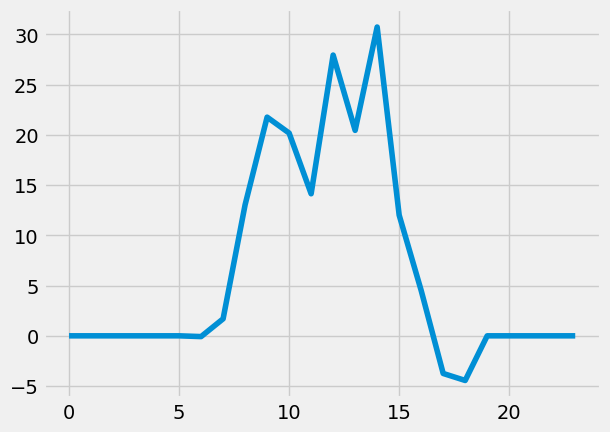

In [53]:
plt.plot(day)
plt.plot([0,0,0,0,0,0]+fres.tolist()+[0,0,0,0,0])

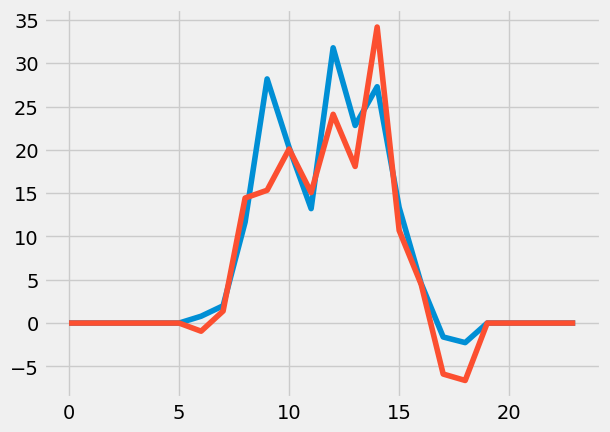

In [52]:
plt.plot([0,0,0,0,0,0]+resultr1.tolist()+[0,0,0,0,0])
plt.plot([0,0,0,0,0,0]+resultr2.tolist()+[0,0,0,0,0])


In [429]:
testMSEnIncentive(fres.tolist(),day)

([191.9454818832244, 51.35655267645031, 8.967107784293239],
 [[24, 0, 0], [0, 0, 111, 136, 112, 32], [16, 8, 0, 0]],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  24,
  0,
  0,
  0,
  0,
  111,
  136,
  112,
  32,
  16,
  8,
  0,
  0,
  0,
  0,
  0,
  0],
 439)